In [1]:
%pylab inline
import emcee
import corner

Populating the interactive namespace from numpy and matplotlib


In [2]:
Fo = 2 * 10 ** 9 # 2 GHz, GPS Frequency
c  = 3 * 10 ** 5 # Km/s

In [3]:
BaseA = np.array([  0,  0, 0])
BaseB = np.array([100,100, 0])
BaseC = np.array([ 50,-50, 0])
BaseD = np.array([-100,10, 1])

In [4]:
class Satellite():
    def __init__(self, X0, Y0, Z0, Vx0, Vy0, Vz0):
        self.x0  = X0
        self.y0  = Y0
        self.z0  = Z0
        self.vx0 = Vx0
        self.vy0 = Vy0
        self.vz0 = Vz0
    
    def position(self, t):
        self.x = self.x0 + self.vx0 * t
        self.y = self.y0 + self.vy0 * t
        self.z = self.z0 + self.vz0 * t
        r = np.array([self.x, self.y, self.z])
        return r
    
    def velocity(self, t):
        self.vx = self.vx0 + 0 * t
        self.vy = self.vy0 + 0 * t
        self.vz = self.vz0 + 0 * t
        v = np.array([self.vx, self.vy, self.vz])
        return v
        
    def rel_vel_to_base(self, t, Base):
        
        r = self.position(t)
        v = self.velocity(t)
        
        x1 = Base[0]
        y1 = Base[1]
        z1 = Base[2]
    
        x_r = r[0] - x1
        y_r = r[1] - y1
        z_r = r[2] - z1  

        d = ( x_r ** 2 + y_r ** 2 + z_r ** 2 )**0.5
    
        ux  = x_r / d
        uy  = y_r / d
        uz  = z_r / d
    
        u = np.array([ux, uy, uz])
        
        return np.inner(-u,v)

# The True Orbit

In [5]:
A = Satellite(-1000, 0, 400, 10, 0, -0.5 )

In [6]:
T = np.linspace(0,200, 10)

In [7]:
v_rel_A = []
v_rel_B = []
v_rel_C = []
v_rel_D = []


for t in T:
    v_rel_A.append(A.rel_vel_to_base(t, BaseA))
    v_rel_B.append(A.rel_vel_to_base(t, BaseB))
    v_rel_C.append(A.rel_vel_to_base(t, BaseC))
    v_rel_D.append(A.rel_vel_to_base(t, BaseD))


v_rel_A  = np.array(v_rel_A)    
v_rel_B  = np.array(v_rel_B)    
v_rel_C  = np.array(v_rel_C)    
v_rel_D  = np.array(v_rel_D)    



V_rel_True = np.hstack((v_rel_A, v_rel_B, v_rel_C, v_rel_D))

# Shift Frequencies
F_A = Fo * (1 + (v_rel_A / c) )
F_B = Fo * (1 + (v_rel_B / c) )
F_C = Fo * (1 + (v_rel_C / c) )
F_D = Fo * (1 + (v_rel_D / c) )


In [8]:
V_rel_True

array([ 9.47046225,  9.16787871,  8.55042003,  7.09669798,  3.45998992,
       -2.59417349, -6.71751442, -8.39945285, -9.09907157, -9.43458891,
        9.53407314,  9.2951276 ,  8.83709905,  7.83616733,  5.38022249,
        0.17030231, -5.17112235, -7.75192217, -8.80094353, -9.2773208 ,
        9.5134604 ,  9.24973178,  8.727613  ,  7.53861553,  4.54559295,
       -1.24197871, -6.05608931, -8.13581311, -8.98063915, -9.37346302,
        9.3440444 ,  8.92681094,  8.02340342,  5.79915011,  0.81265943,
       -4.80922693, -7.62952218, -8.75907366, -9.26177618, -9.518345  ])

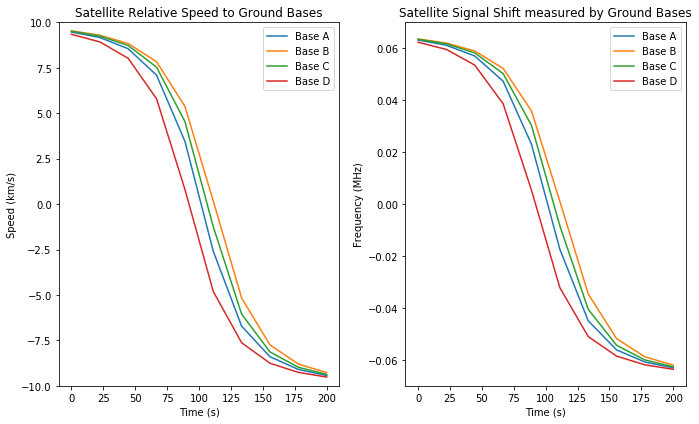

In [9]:
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121)
ax1.set_title("Satellite Relative Speed to Ground Bases")
ax1.set_ylabel("Speed (km/s)")
ax1.set_xlabel("Time (s)")

ax1.plot(T, v_rel_A, label="Base A")
ax1.plot(T, v_rel_B, label="Base B")
ax1.plot(T, v_rel_C, label="Base C")
ax1.plot(T, v_rel_D, label="Base D")

ax1.set_ylim(-10,10)
ax1.legend(loc=0)


#fig = plt.figure(figsize=(10,6))
ax2 = fig.add_subplot(122)
ax2.set_title("Satellite Signal Shift measured by Ground Bases")
ax2.set_ylabel("Frequency (MHz)")
ax2.set_xlabel("Time (s)")

ax2.plot(T, (F_A - Fo)/10**6, label="Base A")
ax2.plot(T, (F_B - Fo)/10**6, label="Base B")
ax2.plot(T, (F_C - Fo)/10**6, label="Base C")
ax2.plot(T, (F_D - Fo)/10**6, label="Base D")

#ax2.set_ylim(-0.1, +0.1)
ax2.legend(loc=0)


plt.tight_layout()

# Now a Monte Carlo!

Lets try a 6 dimentional parameters

In [10]:
def log_likelihood(theta):
    x, y, z, Vx, Vy, Vz = theta
     # Create a Satellite with Random Path
    
    MCsat = Satellite(x, y, z, Vx, Vy, Vz)
    
    # Create a sample of measurements from the 3 Bases
    MCsatV_rel_A = []
    MCsatV_rel_B = []
    MCsatV_rel_C = []
    MCsatV_rel_D = []

    for t in T:
        MCsatV_rel_A.append(MCsat.rel_vel_to_base(t, BaseA))
        MCsatV_rel_B.append(MCsat.rel_vel_to_base(t, BaseB))
        MCsatV_rel_C.append(MCsat.rel_vel_to_base(t, BaseC))
        MCsatV_rel_D.append(MCsat.rel_vel_to_base(t, BaseD))

    MCsatV_rel_A  = np.array(MCsatV_rel_A)    
    MCsatV_rel_B  = np.array(MCsatV_rel_B)    
    MCsatV_rel_C  = np.array(MCsatV_rel_C)    
    MCsatV_rel_D  = np.array(MCsatV_rel_D)    
    
    
    
    MC_V_rel = np.hstack((MCsatV_rel_A, MCsatV_rel_B, MCsatV_rel_C, MCsatV_rel_D))    
    
    chi2 = 0
    wds  = log(2*pi)
    for i in range(3 * len(T)):
        chi2 += (MC_V_rel[i] - V_rel_True[i])**2 + wds
        #print("{}\t{}\t{}".format(MC_V_rel[i],V_rel_True[i], chi2))
        
    return -0.5 * chi2
    

In [35]:
theta = -1000, 0, 400, 10, 0, -0.5
#A = Satellite(-1000, 0, 400, 10, 0, -0.5 )
print (log_likelihood(theta))

nwalkers, ndim = 50, 6
p0 = np.zeros((nwalkers,ndim))

for i in range(nwalkers):
    theta = [-900, 10, 500, 10, 10, -0.5]
    for j in range(ndim):
        p0[i,j] = theta[j]* (0.6 + 0.8 *np.random.rand())

-27.56815599614019


In [41]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
pos, prob, state = sampler.run_mcmc(p0, 200)

In [42]:
sampler.chain.shape

(50, 200, 6)

In [43]:
samples = sampler.chain[:,50:,:].reshape((-1, ndim))

In [44]:
samples.shape

(7500, 6)

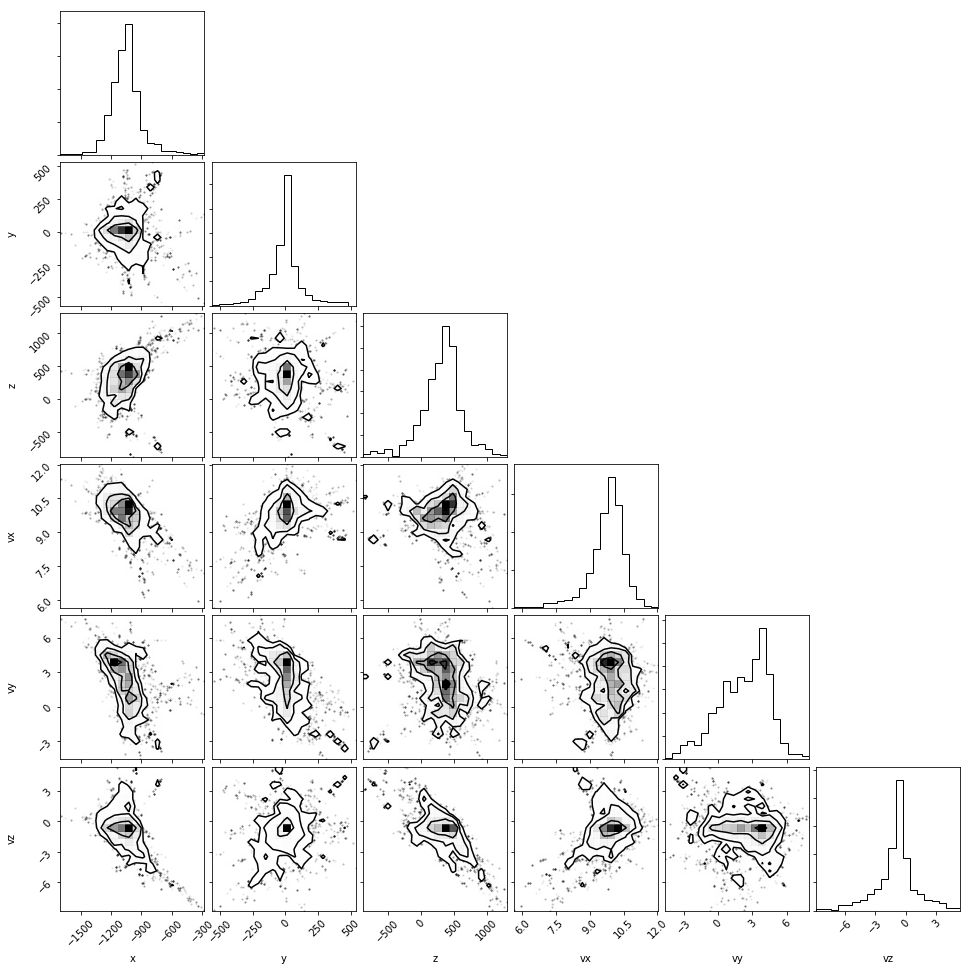

In [45]:
fig = corner.corner(samples, labels=["x", "y", "z", "vx", "vy", "vz"])